Дана таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [39]:
# Импортируем нужные библиотеки
import pandas as pd
import pingouin as pg
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Откроем файл и положим его в датафрейм data
data = pd.read_csv('hw_bootstrap.csv', sep = ';')

In [3]:
# Посмотрим на этот дф
data.head()
# value – значения выручки по каждому пользователю за период эксперимента
# experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


<p>Нулевая гипотеза: между значениями выручки тестовой и контрольной группы значимых различий нет; </p>
Альтернативная гипотеза: между значениями выручки тестовой и контрольной группы есть значимые различия

In [4]:
# Посчитаем количество записей в каждой группе теста - по 500
data.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [5]:
# Проверим наличие пропущенных значений - их нет
data.isna().sum()

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [6]:
# Посмотрим типы колонок - value имеет строковый тип, нужно его перевести во float
data.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [7]:
# Поменяем в колонке value отображение дробных чисел (вместо , поставим .)
data['value'] = data.value.apply(lambda x : x.replace(',', '.'))

In [8]:
# Изменим тип колонки value на float
data = data.astype({'value' : 'float'})

In [9]:
# Положим колонку с выручкой тестовой группы в переменную test
test = data.query('experimentVariant == "Treatment"').value.reset_index(drop=True)

In [10]:
# Положим колонку с выручкой контрольной группы в переменную control
control = data.query('experimentVariant == "Control"').value.reset_index(drop=True)

In [11]:
# Посмотрим на описательные характеристики значений выручки тестовой группы
test.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

In [12]:
# Посмотрим на описательные характеристики значений выручки контрольной группы
control.describe()

count    500.000000
mean      10.026867
std        0.979377
min        6.436541
25%        9.411024
50%       10.018465
75%       10.664879
max       13.130346
Name: value, dtype: float64

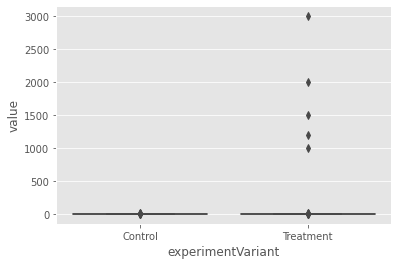

In [13]:
# Построим диаграмму размаха
sns.boxplot(data = data, y = 'value', x = 'experimentVariant')

В тестовой группе есть выбросы, а в контрольной нет. Подтвердим это, построив графики distplot

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


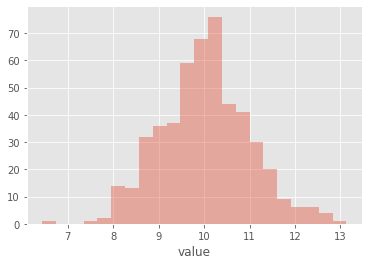

In [14]:
sns.distplot(control, kde = False)

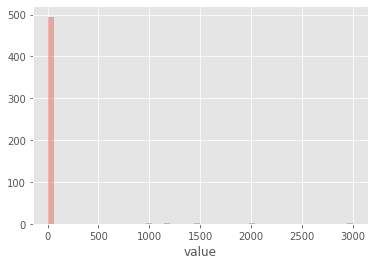

In [15]:
sns.distplot(test, kde = False)

In [16]:
# Уберем выбросы, создав новую переменную test1
test1 = test[test < test.mean() + 3 * test.std()]

In [17]:
# В тестовой выборке без выбросов осталось 495 значений
test1.shape

(495,)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


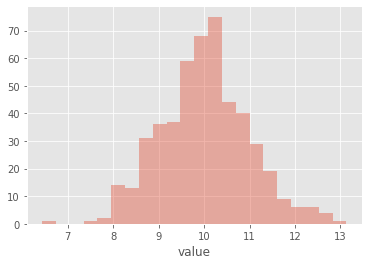

In [18]:
# Построим график тестовой выборки без выбросов
sns.distplot(test1, kde = False)

Далее мы будем анализировать тестовую группу как с выбросами, так и без них

In [19]:
# Проверим распределения во всех группах на нормальность тестом Шапиро-Уилка
stats.shapiro(test)

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

In [20]:
stats.shapiro(test1)

ShapiroResult(statistic=0.9955515265464783, pvalue=0.17188233137130737)

In [21]:
stats.shapiro(control)

ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)

Для контрольной и тестовой группы без выбросов p-value > 0.05, значит оба распределения являются нормальными, а для тестовой группы с выбросами p-value < 0.05, значит распределение в этой группе не является нормальным

In [22]:
# Проверим дисперсии на равенство критерием Бартлетта 
stats.bartlett(test, control)

BartlettResult(statistic=4542.790683960517, pvalue=0.0)

p-value < 0.05 значит дисперсии внутри контрольной и тестовой с выбросами групп имеют значительные различия

In [23]:
stats.bartlett(test1, control)

BartlettResult(statistic=0.0007932459945463393, pvalue=0.9775308526978922)

p-value > 0.05 значит дисперсии внутри контрольной и тестовой без выбросов групп не имеют значимых различий

In [25]:
# Проведем t-test
stats.ttest_ind(test, control)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

P-value < 0.05 что говорит о наличии статистически значимых различий между группами

In [26]:
stats.ttest_ind(test1, control)

Ttest_indResult(statistic=-0.08299135107595523, pvalue=0.9338751428058142)

P-value > 0.05 что говорит о том, что в этом эксперименте мы не смогли доказать наличие статистически значимых различий между группами и отклонить нулевую гипотезу

In [27]:
# Проведем U-test
stats.mannwhitneyu(test, control)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

P-value > 0.05 что говорит о том, что в этом эксперименте мы не смогли доказать наличие статистически значимых различий между группами и отклонить нулевую гипотезу

In [28]:
stats.mannwhitneyu(test1, control)

MannwhitneyuResult(statistic=123310.5, pvalue=0.9228386264147465)

P-value > 0.05 что говорит о том, что в этом эксперименте мы не смогли доказать наличие статистически значимых различий между группами и отклонить нулевую гипотезу

In [44]:
# Проведем бутстрап средних, сначала объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
     # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

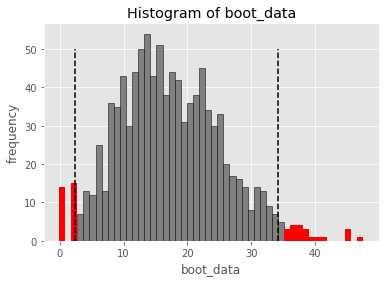

{'quants':                0
 0.025   2.365250
 0.975  34.214847,
 'p_value': 0.03468466601416829}

In [45]:
# Запустим функцию бутстрапа
get_bootstrap(test, control)

P-value < 0.05 что говорит о наличии статистически значимых различий между группами 

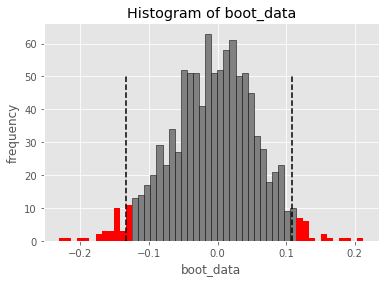

{'quants':               0
 0.025 -0.133370
 0.975  0.109004,
 'p_value': 0.9174610776804227}

In [31]:
get_bootstrap(test1, control)

P-value > 0.05 что говорит о том, что в этом эксперименте мы не смогли доказать наличие статистически значимых различий между группами и отклонить нулевую гипотезу

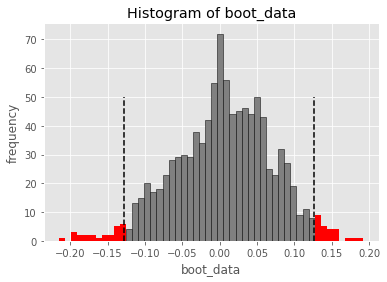

{'quants':               0
 0.025 -0.127313
 0.975  0.126841,
 'p_value': 0.9409394714875212}

In [46]:
# Дополнительно проведем бутстрап-анализ медианы для тестовой группы с выбросами
get_bootstrap(test, control, statistic = np.median)

P-value > 0.05 что говорит о том, что в этом эксперименте мы не смогли доказать наличие статистически значимых различий между группами и отклонить нулевую гипотезу

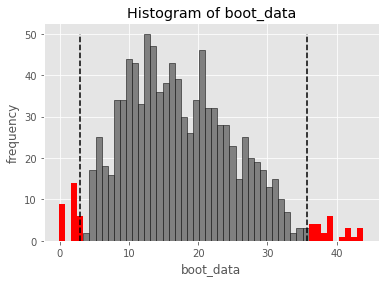

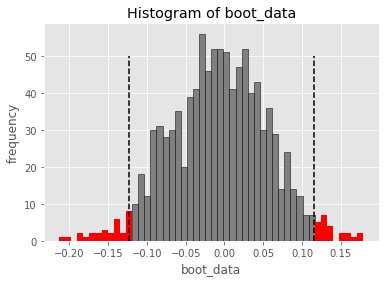

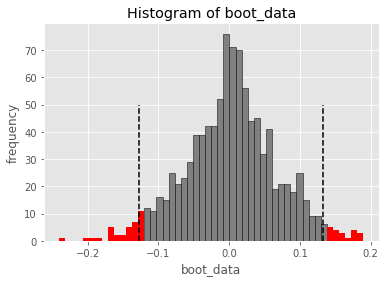

In [47]:
# Подведем итог, собрав p-value из разных тестов в 1 таблицу
d = {'sample': ['test', 'test1'], 
               't-test': [stats.ttest_ind(test, control)[1], stats.ttest_ind(test1, control)[1]],
               'u-test': [stats.mannwhitneyu(test, control)[1], stats.mannwhitneyu(test1, control)[1]],
               'bootstrap': [get_bootstrap(test, control)['p_value'], get_bootstrap(test1, control)['p_value']],
               'bootstrap_median' : [get_bootstrap(test, control, statistic = np.median)['p_value'], '-']}

In [48]:
pvalue = pd.DataFrame(data = d)
pvalue

,sample,t-test,u-test,bootstrap,bootstrap_median
0,test,0.038438,0.859215,0.036696,0.973842
1,test1,0.933875,0.922839,0.913724,-


Выводы:

1. При анализе тестовой группы с выбросами (test) тесты дают разные значения p-value, отличающиеся на порядок: t-test и bootstrap показывают 0.04 (округленно), а u-test - 0.86, bootstrap медианы - 0.97. То есть 2 значения p-value меньше уровня значимости 0.05 (t-test и bootstrap), а 2 больше (u-test и bootstrap медианы). Надо отметить, что 2 значения хоть и меньше, но не сильно меньше уровня значимости, а если бы мы установили его как 0.01, то эти значения превышали бы его. Кроме того, так как распределение тестовой группы с выбросами не является нормальным, а дисперсии внутри контрольной и тестовой с выбросами групп имеют значительные различия, то t-критерий Стьюдента может давать некорректный результат, и стоит ориентироваться на u-критерий Манна-Уитни, который говорит о том, что у нас нет повода отклонить нулевую гипотезу. Об этом же говорит и bootstrap медианы (мы провели его как дополнительную проверку).

2. При анализе тестовой группы без выбросов (test1) все 3 теста дают близкие по значению p-value (округленно 0.93, 0.92, 0.94), на порядок превышающие уровень значимости 0.05. Распределение тестовой группы без выбросов является нормальным, дисперсии внутри контрольной и тестовой без выбросов групп не имеют значительных различий, значит мы можем быть ориентироваться на результат t-критерия Стьюдента.

3. Исходя из написанного выше, мы можем сделать вывод о том, что значимых различий между контрольной и тестовой группой в этом эксперименте обнаружить не удалось, у нас нет повода отклонить нулевую гипотезу. Значит мы не стали больше зарабатывать с пользователя.

4. Также в дальнейшем мы можем посмотреть на 5 пользователей с выбросами (сейчас у нас для этого недостаточно данных) : являются эти значения ошибкой в записи данных или нет, а может у этих пользователей есть много общего (например, источник регистрации, пол и возраст). Это может понадобиться для дальнейших экспериментов, а может и нет.